# Human-in-the-Loop Calculator with LangGraph

This notebook demonstrates a HITL workflow using LangGraph where:
- An LLM processes user questions
- Detects when calculator tool is needed
- Asks human for approval before executing the tool
- Returns results to the user

## 1. Setup and Imports

In [1]:
# Install required packages if needed
!pip install langgraph langchain langchain-openai pydantic python-dotenv

In [2]:
import os
import json
import operator
from typing import TypedDict, Annotated, Sequence, Literal, Optional, Dict, Any, List
from enum import Enum
from datetime import datetime
from pathlib import Path

from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from IPython.display import display, Markdown, clear_output
import time

# Load environment variables early
try:
    from dotenv import load_dotenv
    # Load from multiple possible locations
    env_files = [
        Path.cwd().parent / "infra/.env",  # Use src_path to find infra
        Path.cwd() / ".env",
        Path.cwd().parent / ".env", 
        Path.home() / "agents-app"
    ]
    for env_file in env_files:
        if env_file.exists():
            load_dotenv(env_file, override=False)
            print(f"✅ Loaded environment from {env_file}")
            break
    else:
        print("⚠️ No .env file found in expected locations")
except ImportError:
    print("⚠️ python-dotenv not available, using system environment")

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

print("✅ Imports successful")

✅ Loaded environment from /home/david/WBS-conference-palermo/src/infra/.env
✅ Imports successful


## 2. Define State Model (Pydantic v2)

In [3]:
class ToolCall(BaseModel):
    """Represents a tool call request"""
    tool_name: str = Field(description="Name of the tool to call")
    arguments: Dict[str, Any] = Field(description="Arguments for the tool")
    
class HumanApproval(BaseModel):
    """Human approval for tool execution"""
    approved: bool = Field(description="Whether the tool execution is approved")
    reason: Optional[str] = Field(default=None, description="Reason for approval/rejection")

class GraphState(TypedDict):
    """State for the HITL calculator graph"""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    user_query: str
    pending_tool_call: Optional[Dict[str, Any]]
    human_approval: Optional[Dict[str, Any]]
    result: Optional[str]
    cost: Optional[float]
    
print("✅ State model defined")

✅ State model defined


## 3. Implement Calculator Tool

In [4]:
@tool
def calculator(expression: str) -> str:
    """Evaluate a mathematical expression.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5', '100 / 4')
    
    Returns:
        The result of the calculation as a string
    """
    try:
        # Safe evaluation of mathematical expressions
        # Only allow basic math operations
        allowed_chars = "0123456789+-*/()., "
        if not all(c in allowed_chars for c in expression):
            return f"Error: Invalid characters in expression. Only numbers and basic operators allowed."
        
        result = eval(expression)
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error evaluating expression: {str(e)}"

# Test the calculator
print("Calculator test:")
print(calculator.invoke({"expression": "2 + 2"}))
print(calculator.invoke({"expression": "15 * 3.5"}))
print("✅ Calculator tool implemented")

Calculator test:
The result of 2 + 2 is 4
The result of 15 * 3.5 is 52.5
✅ Calculator tool implemented


## 4. Create LangGraph Nodes

In [5]:
# Initialize the LLM with tool binding
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    openai_api_key=os.getenv("OPENAI_API_KEY")
)

# Bind the calculator tool to the LLM
tools = [calculator]
llm_with_tools = llm.bind_tools(tools)

def process_query(state: GraphState) -> GraphState:
    """Process the user query and determine if calculator is needed"""
    messages = state["messages"]
    
    # Get LLM response with potential tool calls
    response = llm_with_tools.invoke(messages)
    
    # Check if the LLM wants to use a tool
    if response.tool_calls:
        tool_call = response.tool_calls[0]
        state["pending_tool_call"] = {
            "name": tool_call["name"],
            "args": tool_call["args"],
            "id": tool_call["id"]
        }
    
    return {
        "messages": [response],
        "pending_tool_call": state.get("pending_tool_call")
    }

def human_review(state: GraphState) -> GraphState:
    """Get human approval for tool execution"""
    tool_call = state["pending_tool_call"]
    
    if not tool_call:
        return state
    
    # Display tool call for review
    clear_output(wait=True)
    display(Markdown("### 🤖 Tool Execution Request"))
    display(Markdown(f"**Tool:** {tool_call['name']}"))
    display(Markdown(f"**Arguments:** {tool_call['args']}"))
    display(Markdown("---"))
    
    # Get user input
    approval = input("Do you approve this tool execution? (yes/no): ").strip().lower()
    
    approved = approval in ['yes', 'y']
    reason = None
    
    if not approved:
        reason = input("Reason for rejection (optional): ").strip() or "User rejected"
    
    state["human_approval"] = {
        "approved": approved,
        "reason": reason
    }
    
    return state

def execute_tool(state: GraphState) -> GraphState:
    """Execute the approved tool"""
    tool_call = state["pending_tool_call"]
    approval = state["human_approval"]

    if not approval["approved"]:
        # Tool execution was rejected - create a fake tool message to satisfy the API
        rejection_msg = f"Tool execution was rejected by the user: {approval['reason']}"
        tool_message = ToolMessage(
            content=rejection_msg,
            tool_call_id=tool_call["id"]
        )
        return {
            "messages": [tool_message],
            "result": rejection_msg
        }

    # Execute the calculator tool
    result = calculator.invoke(tool_call["args"])

    # Create tool message
    tool_message = ToolMessage(
        content=result,
        tool_call_id=tool_call["id"]
    )

    return {
        "messages": [tool_message],
        "result": result
    }

def generate_final_response(state: GraphState) -> GraphState:
    """Generate the final response after tool execution"""
    messages = state["messages"]

    # Check if we have a pending tool call without human approval (shouldn't happen but safe check)
    if state.get("pending_tool_call") and not state.get("human_approval"):
        # Skip tool execution and provide direct response
        response = AIMessage(content="I can help with that calculation, but I need your approval to use the calculator tool.")
        return {
            "messages": [response],
            "result": response.content
        }

    # Get final response from LLM
    response = llm.invoke(messages)

    return {
        "messages": [response],
        "result": response.content
    }

print("✅ Nodes created")

✅ Nodes created


## 5. Build the Graph

✅ Graph compiled successfully


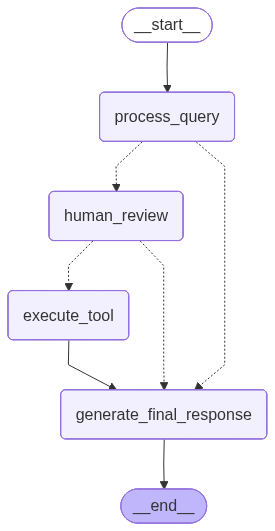

In [6]:
def should_ask_human(state: GraphState) -> Literal["human_review", "generate_final_response"]:
    """Determine if human review is needed"""
    if state.get("pending_tool_call"):
        return "human_review"
    return "generate_final_response"

def should_execute_tool(state: GraphState) -> Literal["execute_tool", "generate_final_response"]:
    """Determine if tool should be executed"""
    approval = state.get("human_approval")
    if approval:
        return "execute_tool"
    return "generate_final_response"

# Build the graph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("process_query", process_query)
workflow.add_node("human_review", human_review)
workflow.add_node("execute_tool", execute_tool)
workflow.add_node("generate_final_response", generate_final_response)

# Set entry point
workflow.set_entry_point("process_query")

# Add edges
workflow.add_conditional_edges(
    "process_query",
    should_ask_human,
    {
        "human_review": "human_review",
        "generate_final_response": "generate_final_response"
    }
)

workflow.add_conditional_edges(
    "human_review",
    should_execute_tool,
    {
        "execute_tool": "execute_tool",
        "generate_final_response": "generate_final_response"
    }
)

workflow.add_edge("execute_tool", "generate_final_response")
workflow.add_edge("generate_final_response", END)

# Compile with memory
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

print("✅ Graph compiled successfully")

# Visualize the graph (optional)
try:
    from IPython.display import Image
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

## 6. Helper Functions

In [7]:
def run_calculator_assistant(query: str, thread_id: str = "default"):
    """Run the HITL calculator assistant"""
    
    # Initialize state
    initial_state = {
        "messages": [
            SystemMessage(content="You are a helpful assistant with access to a calculator. When the user asks a math question, use the calculator tool to help them."),
            HumanMessage(content=query)
        ],
        "user_query": query,
        "pending_tool_call": None,
        "human_approval": None,
        "result": None,
        "cost": None
    }
    
    # Configuration
    config = {
        "configurable": {
            "thread_id": thread_id
        }
    }
    
    # Run the graph
    print(f"\n{'='*60}")
    print(f"📝 Query: {query}")
    print(f"{'='*60}\n")
    
    result = app.invoke(initial_state, config)
    
    # Display final result
    print(f"\n{'='*60}")
    print("✅ Final Response:")
    print(f"{'='*60}")
    print(result["result"])
    print(f"{'='*60}\n")
    
    return result

print("✅ Helper functions ready")

✅ Helper functions ready


## 7. Example Usage

### Example 1: Simple Calculation

In [8]:
# Test with a math question that requires calculator
result = run_calculator_assistant("What is 47 * 23?")

### 🤖 Tool Execution Request

**Tool:** calculator

**Arguments:** {'expression': '47 * 23'}

---


✅ Final Response:
The product of 47 and 23 is 1,081.



### Example 2: Complex Calculation

In [9]:
# Test with a more complex calculation
result = run_calculator_assistant("If I have $1250 and I need to split it equally among 7 people, how much does each person get?")

### 🤖 Tool Execution Request

**Tool:** calculator

**Arguments:** {'expression': '1250 / 7'}

---


✅ Final Response:
To find out how much each person gets, you can divide $1250 by 7. 

Calculating that gives:

\[
1250 \div 7 \approx 178.57
\]

So, each person would get approximately $178.57.



### Example 3: Non-Calculator Question

In [10]:
# Test with a question that doesn't need calculator
result = run_calculator_assistant("What is the capital of France?")


📝 Query: What is the capital of France?


✅ Final Response:
The capital of France is Paris.



### Example 4: Word Problem

In [11]:
# Test with a word problem
result = run_calculator_assistant(
    "A train travels at 60 mph for 2.5 hours. How far does it travel?"
)

### 🤖 Tool Execution Request

**Tool:** calculator

**Arguments:** {'expression': '60 * 2.5'}

---


✅ Final Response:
To find the distance traveled by the train, you can use the formula:

\[
\text{Distance} = \text{Speed} \times \text{Time}
\]

In this case, the speed is 60 mph and the time is 2.5 hours. 

Calculating that gives:

\[
60 \times 2.5 = 150
\]

So, the train travels 150 miles.



## 8. Interactive Session

In [12]:
def interactive_session():
    """Run an interactive HITL calculator session"""
    print("🤖 HITL Calculator Assistant")
    print("Type 'quit' to exit\n")
    
    session_id = f"session_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    
    while True:
        query = input("\nYou: ").strip()
        
        if query.lower() in ['quit', 'exit', 'bye']:
            print("👋 Goodbye!")
            break
        
        if not query:
            continue
        
        try:
            run_calculator_assistant(query, thread_id=session_id)
        except KeyboardInterrupt:
            print("\n⚠️ Interrupted")
            continue
        except Exception as e:
            print(f"\n❌ Error: {e}")
            continue

# Uncomment to run interactive session
# interactive_session()

## 9. Test Suite

In [13]:
def run_tests():
    """Run automated tests (simulating human approval)"""
    test_cases = [
        ("What is 2 + 2?", True),  # Should trigger calculator
        ("Calculate 15% of 200", True),  # Should trigger calculator
        ("What's the weather like?", False),  # Should NOT trigger calculator
    ]
    
    print("🧪 Running Test Suite\n")
    
    for query, should_use_calculator in test_cases:
        print(f"Test: {query}")
        print(f"Expected to use calculator: {should_use_calculator}")
        
        # Create a test state
        test_state = {
            "messages": [
                SystemMessage(content="You are a helpful assistant with access to a calculator."),
                HumanMessage(content=query)
            ],
            "user_query": query,
            "pending_tool_call": None,
            "human_approval": None,
            "result": None,
            "cost": None
        }
        
        # Process query
        result = process_query(test_state)
        used_calculator = result.get("pending_tool_call") is not None
        
        if used_calculator == should_use_calculator:
            print("✅ PASSED\n")
        else:
            print("❌ FAILED\n")
    
    print("🎉 Test suite completed!")

# Run tests
run_tests()

🧪 Running Test Suite

Test: What is 2 + 2?
Expected to use calculator: True
✅ PASSED

Test: Calculate 15% of 200
Expected to use calculator: True
✅ PASSED

Test: What's the weather like?
Expected to use calculator: False
✅ PASSED

🎉 Test suite completed!


## Summary

This notebook demonstrates a complete Human-in-the-Loop workflow with LangGraph featuring:

1. **Pydantic v2 State Management**: Strongly typed state using `GraphState` TypedDict
2. **Calculator Tool**: Safe mathematical expression evaluation
3. **HITL Approval Flow**: Human review before tool execution
4. **Conditional Routing**: Smart graph edges based on state
5. **Memory/Checkpointing**: Session persistence with `MemorySaver`
6. **Interactive Interface**: User-friendly prompts for approval/rejection

The system:
- Detects when calculator is needed based on user query
- Prompts for human approval before executing calculations
- Handles both approved and rejected tool calls gracefully
- Maintains conversation context throughout the session